# 2D Problem

In [2]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS
import jax
import matplotlib.pyplot as plt

Degrees of Freedom: 1089


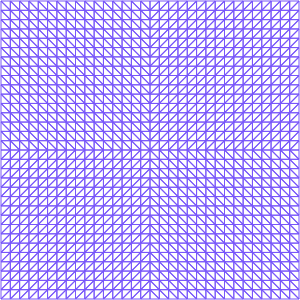

In [3]:
# Create the FEMSystem Object
mesh = fem.MeshTri.init_sqsymmetric().refined(4)
L = 60.0
mesh = mesh.scaled(2 * L).translated((-L, -L))
element = fem.ElementTriP1()
intorder = 4

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)
print(f"Degrees of Freedom: {femsystem.dofs}")
mesh

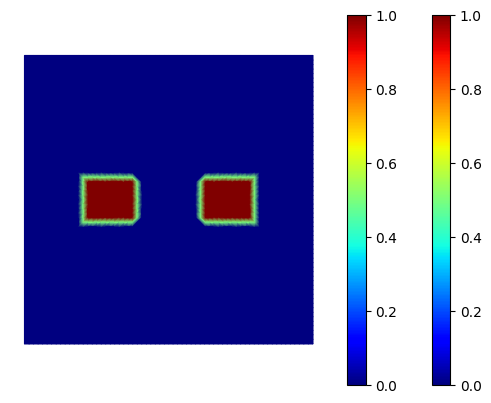

Area is 800
Area Estimate: 843.75


In [4]:
# Step 1: Define the Geometry of two rectangular islands:
sideLen = 20
centerLeft,centerRight = (25,0), (-25,0)
area = 2 * (sideLen ** 2)

def theta(x_vec):
    x,y = x_vec[0],x_vec[1]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
    cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
    return cond1 | cond2

def theta_right_only(x_vec):
    x,y = x_vec[0],x_vec[1]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
    cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
    return cond1

femsystem.plot_func_2d(lambda a,b: theta([a,b]))
print(f"Area is {area}")

# Now get integrated area. 
theta_at_dofs = theta(femsystem.doflocs).astype(jnp.float32)
integrated_area = femsystem.integrate(lambda u,grad_u,x: u,theta_at_dofs)
print(f"Area Estimate: {integrated_area}")

/scratch/gpfs/AROD/vc9839/finite-island-cqed/jax-gpu/lib64/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/scratch/gpfs/AROD/vc9839/finite-island-cqed/jax-gpu/lib64/python3.9/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Vals: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
Coeffs: Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=1/0)>
Plotting the Initial Guess


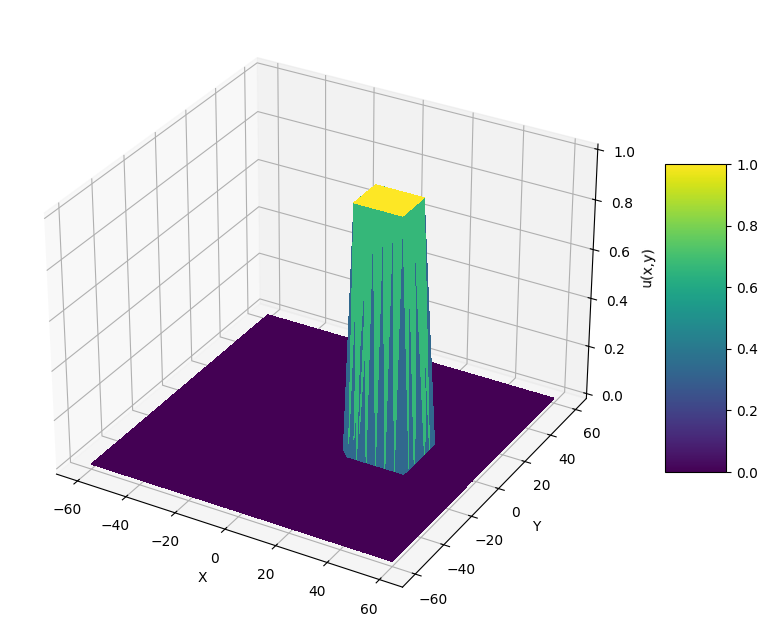

In [5]:
'''
Helper Functions for Integrals
'''

def laplacian(u,grad_u,x):
    return -1*jnp.sum(grad_u**2,axis=0)

# For Potential Energy Double Inetgral, u1 is our function phi_{+/-} and u2 is theta. 
def u_squared(u,grad_u,u2,grad_u2,x):
    return u**2

# Define Pre-Computed Values for Theta and Green's Function:
def theta_func(u,grad_u,u2,grad_u2,x):
    return u2

# U_{++++} or U_{----}, Really N * \alpha
def alpha(u,G_mat):
    return integrated_area  * femsystem.double_integral(lambda u1,a,b,c,d: u1**2,lambda u1,a,b,c,d: u1**2,G_mat,u,u)

# U_{+--+} = U{-++-} - Remember middle two are wrt to y, Outer two wrt to x, from notation used in doc
def beta(u1_arg,u2_arg,G_mat):
    return femsystem.double_integral(lambda u1,a,b,c,d: u1**2, lambda a,b,u2,c,d: u2**2, G_mat, u1_arg,u2_arg)

# U_{++--} = U{+-+-}
def gamma(u1_arg,u2_arg,G_mat):
    return femsystem.double_integral(lambda u1,a,u2,c,d: u1*u2, lambda u1,b,u2,c,d: u1*u2, G_mat, u1_arg,u2_arg)

'''
Helper Functions for Matrices
'''

def Sx(N):
    return Sz(N)

def Sy(N):
    return Sz(N) 

def Sz(N):
    j = (N-1)/2
    diagonals = j - jnp.arange(N)
    return jnp.diag(diagonals)

def expval(mat,vec):
    return jnp.vdot(vec,mat @ vec)

def normalize_vec(vec):
    norm_v = jnp.linalg.norm(vec)
    normalized_v = jnp.where(jnp.isclose(norm_v, 0.0), vec, vec / norm_v )
    return normalized_v

# get first N as the vector of coeffs, remaining as u_interior
def unpack(vec,N):
    coeff_vec,u = vec[:N],vec[N:]
    return coeff_vec,u

# VERY VERY IMPORTANT TO PASS IN G_mat AS AN ARGUMENT, AND SET TO CONSTANT IN OPTIMIZATION LOOP
# This is because when JAX compiles this function, it will treat the G_mat as a "tracer", so just any matrix of constants with some shape. 
# If you hardcode it into the function, it will treat it as an actual part of the code and will spent time compiling a massive amount of hardcoded values as "code" essentially. This is why it takes almost 10 minutes to run first optimization iteration. 
# @jax.jit

'''
Term 1: Zero Point Energy
'''
def epsilon_func(u_global,G_mat,theta_at_dofs):
    # Kinetic Term
    kinetic = -4 * femsystem.integrate(laplacian,u_global)

    # Potential Term
    potential = -2 * femsystem.double_integral(u_squared,theta_func,G_mat,u_global,theta_at_dofs)

    return kinetic  + potential

def E(u_global,G_mat,theta_at_dofs):
    return epsilon_func(u_global,G_mat,theta_at_dofs) + alpha(u_global,G_mat)

def zeropoint(u_even,u_odd,G_mat,theta_at_dofs):
    E_plus,E_minus = E(u_even,G_mat,theta_at_dofs), E(u_odd,G_mat,theta_at_dofs)
    return (E_plus + E_minus) / 2

'''
Term 2: S_z h_z
'''

def h_z(u_even,u_odd,G_mat,theta_at_dofs):
    return epsilon_func(u_even,G_mat,theta_at_dofs) - epsilon_func(u_odd,G_mat,theta_at_dofs) + alpha(u_even,G_mat) - alpha(u_odd,G_mat)

'''
Before you start the optimization loop:
1. Define Objective
2. Compute Interaction Kernel
3. Get Initial Guess
'''

# Set constants
N = 5 # Number of coefficients. NOTE: Just set this to an outside variable. Lots of trouble trying to pass into a dynamical argument, since JAX doesn't like when array indices are dynamical. 

# 1. Defining Objective
@jax.jit
def objective(vec,G_mat,theta_at_dofs):
    # Unpack the modes from the coefficients
    coeff_vec,u_interior = unpack(vec,N)

    # Normalize Coeff Vector: 
    coeff_vec = normalize_vec(coeff_vec)

    # Unpack even and odd modes
    u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)

    # Construct Objective
    e0 = zeropoint(u_even,u_odd,G_mat,theta_at_dofs)
    spinZ = Sz(N)
    term1 = expval(spinZ,coeff_vec) * h_z(u_even,u_odd,G_mat,theta_at_dofs)

    print("Vals:",e0,term1)
    print("Coeffs:",coeff_vec)

    return e0 + term1

# 2. Computing Interaction Kernel
G_mat = femsystem.get_greens_kernel()

# 3. Getting Initial Guess
coeff_vector_init = jnp.ones(N)
u_interior_init = femsystem.ones_on_island(theta_right_only)
initial_guess = jnp.concatenate((coeff_vector_init, u_interior_init), axis=0)

'''
Testing, for a sanity check, and to do a jit compilation
'''
temp = objective(initial_guess,G_mat,theta_at_dofs)
print(f"Plotting the Initial Guess")
femsystem.plot_at_interior_2d_in3d(u_interior_init)

In [6]:
# Optimization Loop
print("Starting Optimization")
solver = LBFGS(fun=objective,tol=1e-2,verbose=True)
result = solver.run(initial_guess,G_mat,theta_at_dofs)
result = result.params 
coeffs,u_interior = unpack(result,N)

Starting Optimization
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 0.6725479364395142 Objective Value:-144.866455078125  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 0.3649882972240448 Objective Value:-144.957275390625  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 0.2585669159889221 Objective Value:-144.97360229492188  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 0.198871448636055 Objective Value:-144.98806762695312  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.33671027421951294 Objective Value:-145.05551147460938  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.23758657276630402 Objective Value:-145.08218383789062  Stepsize:1.0  Number Linesearch

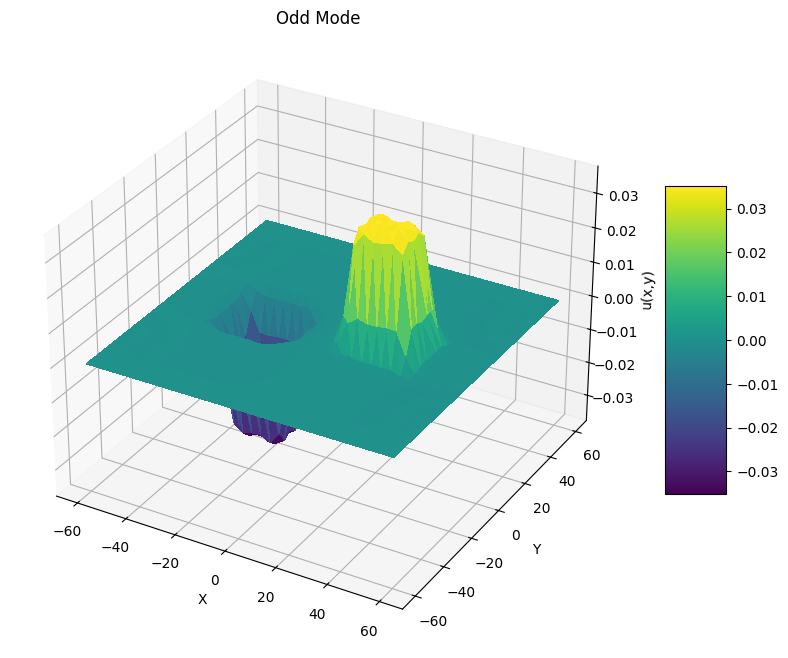

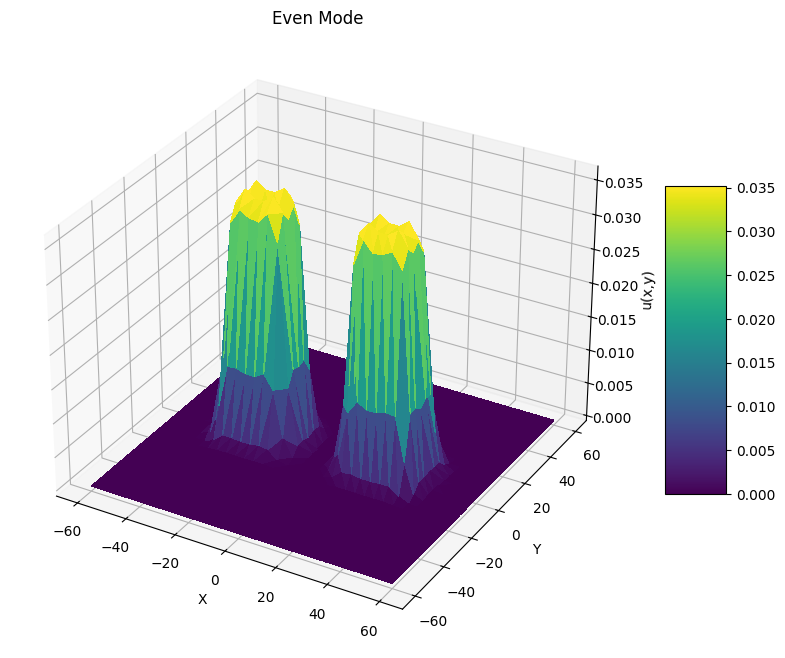

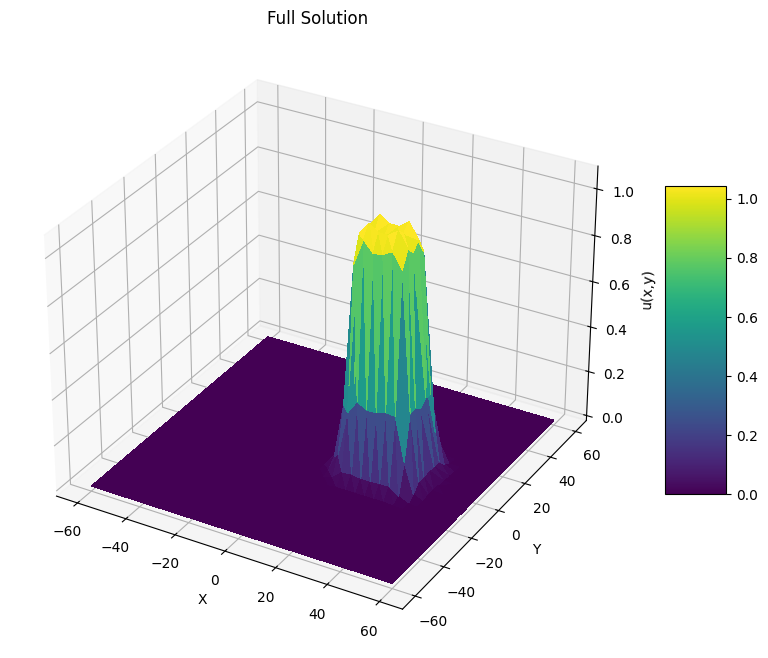

In [7]:
# Plot Solution

# Get Even and Odd Modes
u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)
u_even_interior,u_odd_interior = u_even[femsystem.interior_dofs],u_odd[femsystem.interior_dofs]

femsystem.plot_at_interior_2d_in3d(u_odd_interior,plot_title="Odd Mode")
femsystem.plot_at_interior_2d_in3d(u_even_interior,plot_title="Even Mode")
femsystem.plot_at_interior_2d_in3d(u_interior,plot_title="Full Solution")

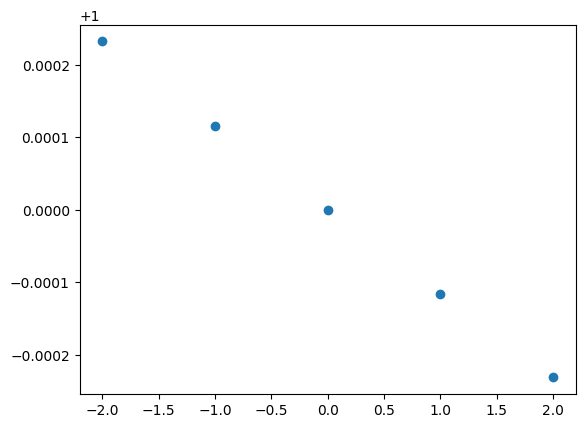

In [8]:
x = (N-1)/2 - jnp.arange(N)
plt.scatter(x,coeffs)